In [1]:
import pickle
import pandas as pd
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.init as init
from torch.autograd import Variable
import torch.utils.data as utils
import itertools
from pandas.core.common import flatten



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
filename = '/scratch/sb3923/time_series/data/data_proc.pickle'
with open(filename, 'rb') as f:
    all_df = pickle.load(f)
    


all_df=all_df.drop(['EtCO2'],axis=1)
all_df['pat_id']=all_df['pat_id'].astype(int)
all_df['hour']=all_df['hour']+1



#need to normalize the data (except the binary)
#drop the binary
all_df=all_df.drop(['Gender'],axis=1)
all_df=all_df.drop(['Unit1'],axis=1)
all_df=all_df.drop(['Unit2'],axis=1)

#normalize the data

for c in all_df.columns:
    all_df[c]=all_df[c]/(all_df[c].max())
    
    
    
all_df = all_df.fillna(0)

#all_df

#to do: drop zero row and below go from 0 to length of the given patient
all_df = all_df.loc[~(all_df.drop(['hour','pat_id'],axis=1)==0).all(axis=1)]

all_df

,hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,pat_id,Age,HospAdmTime,ICULOS,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,SepsisLabel
0,0.020833,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000388,0.978757,-0.111277,0.003300,0.000000,0.000000,0.000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.041667,0.386243,0.990,0.854098,0.366972,0.223333,0.181985,0.239130,0.000388,0.978757,-0.111277,0.006601,-0.161616,0.290909,0.000,0.947849,0.37,0.000,0.000000,0.105263,0.000000,0.336364,0.744681,0.064865,0.0,0.134375,0.069498,0.285714,0.198864,0.346154,0.000000,0.0,0.532362,0.581633,0.000000,0.026957,0.0,0.284916,0.0
2,0.062500,0.386243,1.000,0.000000,0.396330,0.246667,0.205882,0.231884,0.000388,0.978757,-0.111277,0.009901,-0.202020,0.290909,0.000,0.956975,0.25,0.000,0.000000,0.105263,0.000000,0.000000,0.744681,0.000000,0.0,0.000000,0.065637,0.285714,0.000000,0.346154,0.000000,0.0,0.532362,0.581633,0.000000,0.026957,0.0,0.000000,0.0
3,0.083333,0.423280,0.950,0.860493,0.326606,0.206667,0.172794,0.318841,0.000388,0.978757,-0.111277,0.013201,-0.202020,0.000000,0.000,0.956975,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.065637,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,0.104167,0.407407,1.000,0.000000,0.385321,0.233333,0.187500,0.289855,0.000388,0.978757,-0.111277,0.016502,0.000000,0.000000,0.000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
5,0.125000,0.396825,1.000,0.000000,0.398165,0.216667,0.191176,0.275362,0.000388,0.978757,-0.111277,0.019802,0.000000,0.272727,0.000,0.000000,0.00,0.000,0.000000,0.101504,0.000000,0.000000,0.758865,0.059459,0.0,0.123958,0.000000,0.000000,0.000000,0.346154,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
6,0.145833,0.396825,1.000,0.000000,0.396330,0.230000,0.187500,0.188406,0.000388,0.978757,-0.111277,0.023102,-0.141414,0.272727,0.000,0.959583,0.28,0.000,0.000000,0.101504,0.000000,0.000000,0.758865,0.000000,0.0,0.000000,0.081081,0.000000,0.000000,0.346154,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
7,0.166667,0.417989,1.000,0.868546,0.379817,0.210000,0.191176,0.231884,0.000388,0.978757,-0.111277,0.026403,-0.141414,0.000000,0.000,0.959583,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.081081,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
8,0.187500,0.423280,1.000,0.000000,0.380734,0.193333,0.202206,0.260870,0.000388,0.978757,-0.111277,0.029703,0.000000,0.000000,0.000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
9,0.208333,0.417989,1.000,0.000000,0.354128,0.203333,0.172794,0.246377,0.000388,0.978757,-0.111277,0.033003,0.000000,0.000000,0.000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


In [3]:
all_df.shape

(201546, 39)

In [4]:
#train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean = PrepareDataset(all_df.iloc[:12000,:], BATCH_SIZE =32 , masking = True)


In [5]:

def PrepareDataset(data, \
                   BATCH_SIZE = 64, \
                   seq_len = 12, \
                   pred_len = 1, \
                   train_propotion = 0.7, \
                   valid_propotion = 0.2, \
                   masking = False, \
                   mask_ones_proportion = 0.8):
    """ Prepare training and testing datasets and dataloaders.
    
    Convert speed/volume/occupancy matrix to training and testing dataset. 
    The vertical axis of speed_matrix is the time axis and the horizontal axis 
    is the spatial axis.
    
    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    time_len = data.shape[0]
    #speed_matrix = speed_matrix.clip(0, 100) #limit the values to 0-100
    
    max_data = data.max().max()
    #speed_matrix =  speed_matrix / max_speed
    
    data_sequences, data_labels = [], []
    for p in data['pat_id'].unique():
        pat_len = len(data[data['pat_id']==p])
        if (pat_len>(seq_len+pred_len)):
        #for i in range(time_len - seq_len - pred_len):
            for i in range(pat_len - seq_len - pred_len):
                data_sequences.append(data.drop(['SepsisLabel'], axis=1)[data['pat_id']==p].iloc[i:i+seq_len].values)
                data_labels.append(data['SepsisLabel'][data['pat_id']==p].iloc[i+seq_len:i+seq_len+pred_len].values)
                #data_labels.append(data.drop(['SepsisLabel'], axis=1)[data['pat_id']==p].iloc[i+seq_len:i+seq_len+pred_len].values)
                #data_sequences.append(data[data['pat_id']==p].iloc[i:i+seq_len].values)
                #data_labels.append(data[data['pat_id']==p].iloc[i+seq_len:i+seq_len+pred_len].values)

    #print(i)
    data_sequences, data_labels = np.asarray(data_sequences), np.asarray(data_labels)
    #print(data_sequences.shape)
    #(951, 48, 42)
    if masking:
        print('Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...')
        np.random.seed(1024)
        #Mask = np.random.choice([0,1], size=(data_sequences.shape), p = [1 - mask_ones_proportion, mask_ones_proportion])
        #speed_sequences = np.multiply(speed_sequences, Mask)
        Mask = data_sequences
        Mask[Mask!=0]=1
        
        
        # temporal information
        interval = 1 # 5 minutes
        S = np.zeros_like(data_sequences) # time stamps
        for i in range(S.shape[1]):
            S[:,i,:] = interval * i
            
        #print(S)
        Delta = np.zeros_like(data_sequences) # time intervals
        for i in range(1, S.shape[1]):
            Delta[:,i,:] = S[:,i,:] - S[:,i-1,:]

        missing_index = np.where(Mask == 0)

        X_last_obsv = np.copy(data_sequences)
        for idx in range(missing_index[0].shape[0]):
            i = missing_index[0][idx] 
            j = missing_index[1][idx]
            k = missing_index[2][idx]
            if j != 0 and j != (seq_len-1):
                Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
            if j != 0:
                X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation
        
        #this should be column wise
        Delta = Delta / Delta.max() # normalize
    
    # shuffle and split the dataset to training and testing datasets
    print('Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...')
    sample_size = data_sequences.shape[0]/48
    index_ = np.arange(sample_size, dtype = int)
    np.random.seed(1024)
    np.random.shuffle(index_)
    
    index=[]
    for i in index_:
        index.append(list(range(i,i+48)))
     
    index=list(flatten(index))
    
       
    data_sequences = data_sequences[index]
    data_labels = data_labels[index]
    

    if masking:
        X_last_obsv = X_last_obsv[index]
        Mask = Mask[index]
        Delta = Delta[index]
        data_sequences = np.expand_dims(data_sequences, axis=1)
        X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
        Mask = np.expand_dims(Mask, axis=1)
        Delta = np.expand_dims(Delta, axis=1)
        dataset_agger = np.concatenate((data_sequences, X_last_obsv, Mask, Delta), axis = 1)
        
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    if masking:
        train_data, train_label = dataset_agger[:train_index], data_labels[:train_index]
        valid_data, valid_label = dataset_agger[train_index:valid_index], data_labels[train_index:valid_index]
        test_data, test_label = dataset_agger[valid_index:], data_labels[valid_index:]
    else:
        train_data, train_label = data_sequences[:train_index], data_labels[:train_index]
        valid_data, valid_label = data_sequences[train_index:valid_index], data_labels[train_index:valid_index]
        test_data, test_label = data_sequences[valid_index:], data_labels[valid_index:]
    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    X_mean = np.mean(data_sequences, axis = 0)
    
    print('Finished')
    
    return train_dataloader, valid_dataloader, test_dataloader, max_data, X_mean

In [6]:
def Train_Model(model, train_dataloader, valid_dataloader, num_epochs = 300, patience = 10, min_delta = 0.00001):
    
    print('Model Structure: ', model)
    print('Start Training ... ')
    
    model.cuda()
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
        print('Output type dermined by the last layer')
    else:
        output_last = model.output_last
        print('Output type dermined by the model')
        
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()
    loss_CE=torch.nn.CrossEntropyLoss()
    loss_BCE=torch.nn.BCELoss()
    fc = torch.nn.Linear(38, 1)
    
    learning_rate = 0.0001
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate, alpha=0.99)
    use_gpu = torch.cuda.is_available()
    
    interval = 100
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    for epoch in range(num_epochs):
        
        trained_number = 0
        
        valid_dataloader_iter = iter(valid_dataloader)
        
        losses_epoch_train = []
        losses_epoch_valid = []
        
        for data in train_dataloader:
            inputs, labels = data

            if inputs.shape[0] != batch_size:
                continue

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else: 
                inputs, labels = Variable(inputs), Variable(labels)
            
            model.zero_grad()

            #here pass the first columns of the model and labels become the last element
            
            #inputs doesnt include the sepsis label
            outputs = model(inputs)
         
            #print('model output:')
            #print(outputs)
            #print('lables:')
            #print(labels)
            
            if output_last:
                #loss_train = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels))
                loss_train = loss_BCE(torch.squeeze(outputs),torch.squeeze(labels) )
            else:
                #full_labels = torch.cat((inputs[:,1:,:], labels), dim = 1)
                #loss_train = loss_MSE(outputs, full_labels)
                loss_train = loss_BCE(torch.squeeze(outputs),torch.squeeze(labels) )

        
            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
             # validation 
            try: 
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)
            
            if use_gpu:
                inputs_val, labels_val = Variable(inputs_val.cuda()), Variable(labels_val.cuda())
            else: 
                inputs_val, labels_val = Variable(inputs_val), Variable(labels_val)
                
            model.zero_grad()
            
            outputs_val = model(inputs_val)
            
            if output_last:
                #loss_valid = loss_MSE(torch.squeeze(outputs_val), torch.squeeze(labels_val))
                loss_valid = loss_BCE(torch.squeeze(outputs_val),torch.squeeze(labels_val) )
            else:
                #full_labels_val = torch.cat((inputs_val[:,1:,:], labels_val), dim = 1)
                #loss_valid = loss_MSE(outputs_val, full_labels_val)
                loss_valid = loss_BCE(torch.squeeze(outputs_val),torch.squeeze(labels_val) )


            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)
            
            # output
            trained_number += 1
            
        avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid).cpu().numpy() / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(avg_losses_epoch_valid, decimals=8),\
                    np.around([cur_time - pre_time] , decimals=2),\
                    is_best_model) )
        pre_time = cur_time
                
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]



In [7]:
def Test_Model(model, test_dataloader, max_speed):
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
    else:
        output_last = model.output_last
    
    inputs, labels = next(iter(test_dataloader))
    [batch_size, type_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()
    
    tested_batch = 0
    
    losses_mse = []
    losses_l1 = [] 
    MAEs = []
    MAPEs = []

    
    for data in test_dataloader:
        inputs, labels = data
        
        if inputs.shape[0] != batch_size:
            continue
    
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: 
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
    
        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()
        
        if output_last:
            loss_mse = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels))
            loss_l1 = loss_L1(torch.squeeze(outputs), torch.squeeze(labels))
            MAE = torch.mean(torch.abs(torch.squeeze(outputs) - torch.squeeze(labels)))
            MAPE = torch.mean(torch.abs(torch.squeeze(outputs) - torch.squeeze(labels)) / torch.squeeze(labels))
        else:
            loss_mse = loss_MSE(outputs[:,-1,:], labels)
            loss_l1 = loss_L1(outputs[:,-1,:], labels)
            MAE = torch.mean(torch.abs(outputs[:,-1,:] - torch.squeeze(labels)))
            MAPE = torch.mean(torch.abs(outputs[:,-1,:] - torch.squeeze(labels)) / torch.squeeze(labels))
            
        losses_mse.append(loss_mse.data)
        losses_l1.append(loss_l1.data)
        MAEs.append(MAE.data)
        MAPEs.append(MAPE.data)
        
        tested_batch += 1
    
        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print('Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}'.format( \
                  tested_batch * batch_size, \
                  np.around([loss_l1.data[0]], decimals=8), \
                  np.around([loss_mse.data[0]], decimals=8), \
                  np.around([cur_time - pre_time], decimals=8) ) )
            pre_time = cur_time
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    MAEs = np.array(MAEs)
    MAPEs = np.array(MAPEs)
    
    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    MAE_ = np.mean(MAEs) * max_speed
    MAPE_ = np.mean(MAPEs) * 100
    
    print('Tested: L1_mean: {}, L1_std: {}, MAE: {} MAPE: {}'.format(mean_l1, std_l1, MAE_, MAPE_))
    return [losses_l1, losses_mse, mean_l1, std_l1]




In [8]:
from GRUD import * 


train_dataloader, valid_dataloader, test_dataloader, max_dat, X_mean = PrepareDataset(all_df.iloc[:12000,:], BATCH_SIZE = 32, masking = True)
#train_dataloader, valid_dataloader, test_dataloader, max_dat, X_mean = PrepareDataset(all_df, BATCH_SIZE = 32, masking = True)

inputs, labels = next(iter(train_dataloader))

#print(inputs.size())
#print(labels.size())

[batch_size, type_size, step_size, fea_size] = inputs.size()
#[batch_size,  fea_size] = inputs.size()

#fea_size -, because we need to exclude the labels
input_dim = fea_size
hidden_dim = fea_size
output_dim = fea_size
    
grud = GRUD(input_dim, hidden_dim, output_dim, X_mean, output_last = True)
best_grud, losses_grud = Train_Model(grud, train_dataloader, valid_dataloader)
[losses_l1, losses_mse, mean_l1, std_l1] = Test_Model(best_grud, test_dataloader, max_dat)



Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...
Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...
Finished
Model Structure:  GRUD (
  (fc): Linear (38 -> 1)
  (sigmoid): Sigmoid ()
  (zl): Linear (114 -> 38)
  (rl): Linear (114 -> 38)
  (hl): Linear (114 -> 38)
  (gamma_x_l): FilterLinear(in_features=38, out_features=38, bias=True)
  (gamma_h_l): Linear (38 -> 38)
)
Start Training ... 
Output type dermined by the model
Epoch: 0, train_loss: [ 0.64693421], valid_loss: [ 0.62625062], time: [ 0.48], best model: 1
Epoch: 1, train_loss: [ 0.5541327], valid_loss: [ 0.54951191], time: [ 0.34], best model: 1
Epoch: 2, train_loss: [ 0.50100231], valid_loss: [ 0.49831581], time: [ 0.35], best model: 1
Epoch: 3, train_loss: [ 0.46477881], valid_loss: [ 0.46001613], time: [ 0.31], best model: 1
Epoch: 4, train_loss: [ 0.43212023], valid_loss: [ 0.42747319], time: [ 0.33], best model: 1
Epoch: 5, train_loss: [ 0.40065596], valid_loss: [ 

In [10]:
#! pwd

/scratch/sb3923/time_series/EarlySepsisPrediction/RNN-missingval


In [12]:
#torch.save(best_grud.state_dict(), '/scratch/sb3923/time_series/EarlySepsisPrediction/RNN-missingval/checkpoints/best_grud.pth')


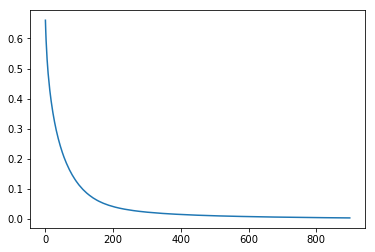

In [17]:
import matplotlib.pyplot as plt
val_losses=[]
train_losses=[]

for lg in range(len(losses_grud[1])):
    val_losses.append(losses_grud[1][lg].cpu().numpy())
    train_losses.append(losses_grud[0][lg].cpu().numpy())

plt.plot(val_losses)
plt.show()

#[losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]

In [13]:
#torch.save(losses_grud, "/scratch/sb3923/time_series/EarlySepsisPrediction/RNN-missingval/checkpoints/losses_grud.pt")


In [16]:
#t7_data = torch.load('/scratch/sb3923/time_series/EarlySepsisPrediction/RNN-missingval/checkpoints/losses_grud.pt')

#losses_grud=t7_data

In [ ]:
#plt.plot(train_losses)
#plt.show()

In [ ]:
inputs#.size()

In [ ]:
def PrepareDataset(speed_matrix, \
                   BATCH_SIZE = 40, \
                   seq_len = 10, \
                   pred_len = 1, \
                   train_propotion = 0.7, \
                   valid_propotion = 0.2, \
                   masking = False, \
                   mask_ones_proportion = 0.8):
    """ Prepare training and testing datasets and dataloaders.
    
    Convert speed/volume/occupancy matrix to training and testing dataset. 
    The vertical axis of speed_matrix is the time axis and the horizontal axis 
    is the spatial axis.
    
    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    time_len = speed_matrix.shape[0]
    
    speed_matrix = speed_matrix.clip(0, 100)
    
    max_speed = speed_matrix.max().max()
    speed_matrix =  speed_matrix / max_speed
    
    speed_sequences, speed_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix.iloc[i:i+seq_len].values)
        speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
    speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
    
    # using zero-one mask to randomly set elements to zeros
    if masking:
        print('Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...')
        np.random.seed(1024)
        Mask = np.random.choice([0,1], size=(speed_sequences.shape), p = [1 - mask_ones_proportion, mask_ones_proportion])
        speed_sequences = np.multiply(speed_sequences, Mask)
        
        # temporal information
        interval = 5 # 5 minutes
        S = np.zeros_like(speed_sequences) # time stamps
        for i in range(S.shape[1]):
            S[:,i,:] = interval * i

        Delta = np.zeros_like(speed_sequences) # time intervals
        for i in range(1, S.shape[1]):
            Delta[:,i,:] = S[:,i,:] - S[:,i-1,:]

        missing_index = np.where(Mask == 0)

        X_last_obsv = np.copy(speed_sequences)
        for idx in range(missing_index[0].shape[0]):
            i = missing_index[0][idx] 
            j = missing_index[1][idx]
            k = missing_index[2][idx]
            if j != 0 and j != 9:
                Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
            if j != 0:
                X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation
        Delta = Delta / Delta.max() # normalize
    
    # shuffle and split the dataset to training and testing datasets
    print('Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...')
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.seed(1024)
    np.random.shuffle(index)
    
    speed_sequences = speed_sequences[index]
    speed_labels = speed_labels[index]
    
    if masking:
        X_last_obsv = X_last_obsv[index]
        Mask = Mask[index]
        Delta = Delta[index]
        speed_sequences = np.expand_dims(speed_sequences, axis=1)
        X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
        Mask = np.expand_dims(Mask, axis=1)
        Delta = np.expand_dims(Delta, axis=1)
        dataset_agger = np.concatenate((speed_sequences, X_last_obsv, Mask, Delta), axis = 1)
        
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    if masking:
        train_data, train_label = dataset_agger[:train_index], speed_labels[:train_index]
        valid_data, valid_label = dataset_agger[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = dataset_agger[valid_index:], speed_labels[valid_index:]
    else:
        train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
        valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]
    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    X_mean = np.mean(speed_sequences, axis = 0)
    
    print('Finished')
    
    return train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean

In [ ]:
speed_matrix =  pd.read_pickle('/scratch/sb3923/time_series/data/speed_matrix_2015')

train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean = PrepareDataset(speed_matrix.iloc[:1000,:20], BATCH_SIZE = 64, masking = True)
    
inputs, labels = next(iter(train_dataloader))
inputs

In [ ]:
[batch_size, type_size, step_size, fea_size] = inputs.size()
input_dim = fea_size
hidden_dim = fea_size
output_dim = fea_size
    
grud = GRUD(input_dim, hidden_dim, output_dim, X_mean, output_last = True)
best_grud, losses_grud = Train_Model(grud, train_dataloader, valid_dataloader)
[losses_l1, losses_mse, mean_l1, std_l1] = Test_Model(best_grud, test_dataloader, max_speed)

In [ ]:
speed_matrix =  pd.read_pickle('/scratch/sb3923/time_series/data/speed_matrix_2015')


In [ ]:
print(speed_matrix.shape)
time_len = speed_matrix.shape[0]
speed_matrix = speed_matrix.clip(0, 100)
speed_matrix.shape
max_speed = speed_matrix.max().max()
speed_matrix =  speed_matrix / max_speed
print(speed_matrix.shape)


In [ ]:
BATCH_SIZE = 40
seq_len = 10
pred_len = 1
train_propotion = 0.7
valid_propotion = 0.2
masking = False
mask_ones_proportion = 0.8

speed_sequences, speed_labels = [], []
for i in range(time_len - seq_len - pred_len):
    speed_sequences.append(speed_matrix.iloc[i:i+seq_len].values)
    speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
    
speed_sequences.shape

In [ ]:
speed_labels.shape

In [ ]:
speed_matrix.iloc[i:i+seq_len].shape

In [ ]:
 time_len = speed_matrix.shape[0]
    
    speed_matrix = speed_matrix.clip(0, 100)
    
    max_speed = speed_matrix.max().max()
    speed_matrix =  speed_matrix / max_speed
    
    speed_sequences, speed_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix.iloc[i:i+seq_len].values)
        speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
    speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
    
    # using zero-one mask to randomly set elements to zeros
    if masking:
        print('Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...')
        np.random.seed(1024)
        Mask = np.random.choice([0,1], size=(speed_sequences.shape), p = [1 - mask_ones_proportion, mask_ones_proportion])
        speed_sequences = np.multiply(speed_sequences, Mask)
        
        # temporal information
        interval = 5 # 5 minutes
        S = np.zeros_like(speed_sequences) # time stamps
        for i in range(S.shape[1]):
            S[:,i,:] = interval * i

        Delta = np.zeros_like(speed_sequences) # time intervals
        for i in range(1, S.shape[1]):
            Delta[:,i,:] = S[:,i,:] - S[:,i-1,:]

        missing_index = np.where(Mask == 0)

        X_last_obsv = np.copy(speed_sequences)
        for idx in range(missing_index[0].shape[0]):
            i = missing_index[0][idx] 
            j = missing_index[1][idx]
            k = missing_index[2][idx]
            if j != 0 and j != 9:
                Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
            if j != 0:
                X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation
        Delta = Delta / Delta.max() # normalize
    
    # shuffle and split the dataset to training and testing datasets
    print('Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...')
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.seed(1024)
    np.random.shuffle(index)
    
    speed_sequences = speed_sequences[index]
    speed_labels = speed_labels[index]
    
    if masking:
        X_last_obsv = X_last_obsv[index]
        Mask = Mask[index]
        Delta = Delta[index]
        speed_sequences = np.expand_dims(speed_sequences, axis=1)
        X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
        Mask = np.expand_dims(Mask, axis=1)
        Delta = np.expand_dims(Delta, axis=1)
        dataset_agger = np.concatenate((speed_sequences, X_last_obsv, Mask, Delta), axis = 1)
        
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    if masking:
        train_data, train_label = dataset_agger[:train_index], speed_labels[:train_index]
        valid_data, valid_label = dataset_agger[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = dataset_agger[valid_index:], speed_labels[valid_index:]
    else:
        train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
        valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]
    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    X_mean = np.mean(speed_sequences, axis = 0)
    

In [ ]:
from GRUD import * 

def PrepareDataset(speed_matrix, \
                   BATCH_SIZE = 40, \
                   seq_len = 10, \
                   pred_len = 1, \
                   train_propotion = 0.7, \
                   valid_propotion = 0.2, \
                   masking = False, \
                   mask_ones_proportion = 0.8):
    """ Prepare training and testing datasets and dataloaders.
    
    Convert speed/volume/occupancy matrix to training and testing dataset. 
    The vertical axis of speed_matrix is the time axis and the horizontal axis 
    is the spatial axis.
    
    Args:
        speed_matrix: a Matrix containing spatial-temporal speed data for a network
        seq_len: length of input sequence
        pred_len: length of predicted sequence
    Returns:
        Training dataloader
        Testing dataloader
    """
    time_len = speed_matrix.shape[0]
    
    speed_matrix = speed_matrix.clip(0, 100)
    
    max_speed = speed_matrix.max().max()
    speed_matrix =  speed_matrix / max_speed
    
    speed_sequences, speed_labels = [], []
    for i in range(time_len - seq_len - pred_len):
        speed_sequences.append(speed_matrix.iloc[i:i+seq_len].values)
        speed_labels.append(speed_matrix.iloc[i+seq_len:i+seq_len+pred_len].values)
    speed_sequences, speed_labels = np.asarray(speed_sequences), np.asarray(speed_labels)
    
    # using zero-one mask to randomly set elements to zeros
    if masking:
        print('Split Speed finished. Start to generate Mask, Delta, Last_observed_X ...')
        np.random.seed(1024)
        Mask = np.random.choice([0,1], size=(speed_sequences.shape), p = [1 - mask_ones_proportion, mask_ones_proportion])
        speed_sequences = np.multiply(speed_sequences, Mask)
        
        # temporal information
        interval = 5 # 5 minutes
        S = np.zeros_like(speed_sequences) # time stamps
        for i in range(S.shape[1]):
            S[:,i,:] = interval * i

        Delta = np.zeros_like(speed_sequences) # time intervals
        for i in range(1, S.shape[1]):
            Delta[:,i,:] = S[:,i,:] - S[:,i-1,:]

        missing_index = np.where(Mask == 0)

        X_last_obsv = np.copy(speed_sequences)
        for idx in range(missing_index[0].shape[0]):
            i = missing_index[0][idx] 
            j = missing_index[1][idx]
            k = missing_index[2][idx]
            if j != 0 and j != 9:
                Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
            if j != 0:
                X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation
        Delta = Delta / Delta.max() # normalize
    
    # shuffle and split the dataset to training and testing datasets
    print('Generate Mask, Delta, Last_observed_X finished. Start to shuffle and split dataset ...')
    sample_size = speed_sequences.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.seed(1024)
    np.random.shuffle(index)
    
    speed_sequences = speed_sequences[index]
    speed_labels = speed_labels[index]
    
    if masking:
        X_last_obsv = X_last_obsv[index]
        Mask = Mask[index]
        Delta = Delta[index]
        speed_sequences = np.expand_dims(speed_sequences, axis=1)
        X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
        Mask = np.expand_dims(Mask, axis=1)
        Delta = np.expand_dims(Delta, axis=1)
        dataset_agger = np.concatenate((speed_sequences, X_last_obsv, Mask, Delta), axis = 1)
        
    train_index = int(np.floor(sample_size * train_propotion))
    valid_index = int(np.floor(sample_size * ( train_propotion + valid_propotion)))
    
    if masking:
        train_data, train_label = dataset_agger[:train_index], speed_labels[:train_index]
        valid_data, valid_label = dataset_agger[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = dataset_agger[valid_index:], speed_labels[valid_index:]
    else:
        train_data, train_label = speed_sequences[:train_index], speed_labels[:train_index]
        valid_data, valid_label = speed_sequences[train_index:valid_index], speed_labels[train_index:valid_index]
        test_data, test_label = speed_sequences[valid_index:], speed_labels[valid_index:]
    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)
    
    train_dataset = utils.TensorDataset(train_data, train_label)
    valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, drop_last = True)
    
    X_mean = np.mean(speed_sequences, axis = 0)
    
    print('Finished')
    
    return train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean



def Train_Model(model, train_dataloader, valid_dataloader, num_epochs = 300, patience = 10, min_delta = 0.00001):
    
    print('Model Structure: ', model)
    print('Start Training ... ')
    
    model.cuda()
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
        print('Output type dermined by the last layer')
    else:
        output_last = model.output_last
        print('Output type dermined by the model')
        
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.L1Loss()
    
    learning_rate = 0.0001
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate, alpha=0.99)
    use_gpu = torch.cuda.is_available()
    
    interval = 100
    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    for epoch in range(num_epochs):
        
        trained_number = 0
        
        valid_dataloader_iter = iter(valid_dataloader)
        
        losses_epoch_train = []
        losses_epoch_valid = []
        
        for data in train_dataloader:
            inputs, labels = data

            if inputs.shape[0] != batch_size:
                continue

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else: 
                inputs, labels = Variable(inputs), Variable(labels)
            
            model.zero_grad()

            outputs = model(inputs)
            
            #print('outputs')
            #print(outputs)
            #print('labels')
            #print(labels)
            
            if output_last:
                loss_train = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels))
            else:
                full_labels = torch.cat((inputs[:,1:,:], labels), dim = 1)
                loss_train = loss_MSE(outputs, full_labels)
        
            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
             # validation 
            try: 
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)
            
            if use_gpu:
                inputs_val, labels_val = Variable(inputs_val.cuda()), Variable(labels_val.cuda())
            else: 
                inputs_val, labels_val = Variable(inputs_val), Variable(labels_val)
                
            model.zero_grad()
            
            outputs_val = model(inputs_val)
            
            if output_last:
                loss_valid = loss_MSE(torch.squeeze(outputs_val), torch.squeeze(labels_val))
            else:
                full_labels_val = torch.cat((inputs_val[:,1:,:], labels_val), dim = 1)
                loss_valid = loss_MSE(outputs_val, full_labels_val)

            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)
            
            # output
            trained_number += 1
            
        avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid).cpu().numpy() / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(avg_losses_epoch_valid, decimals=8),\
                    np.around([cur_time - pre_time] , decimals=2),\
                    is_best_model) )
        pre_time = cur_time
                
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]


def Test_Model(model, test_dataloader, max_speed):
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
    else:
        output_last = model.output_last
    
    inputs, labels = next(iter(test_dataloader))
    [batch_size, type_size, step_size, fea_size] = inputs.size()

    cur_time = time.time()
    pre_time = time.time()
    
    use_gpu = torch.cuda.is_available()
    
    loss_MSE = torch.nn.MSELoss()
    loss_L1 = torch.nn.MSELoss()
    
    tested_batch = 0
    
    losses_mse = []
    losses_l1 = [] 
    MAEs = []
    MAPEs = []

    
    for data in test_dataloader:
        inputs, labels = data
        
        if inputs.shape[0] != batch_size:
            continue
    
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else: 
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
    
        loss_MSE = torch.nn.MSELoss()
        loss_L1 = torch.nn.L1Loss()
        
        if output_last:
            loss_mse = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels))
            loss_l1 = loss_L1(torch.squeeze(outputs), torch.squeeze(labels))
            MAE = torch.mean(torch.abs(torch.squeeze(outputs) - torch.squeeze(labels)))
            MAPE = torch.mean(torch.abs(torch.squeeze(outputs) - torch.squeeze(labels)) / torch.squeeze(labels))
        else:
            loss_mse = loss_MSE(outputs[:,-1,:], labels)
            loss_l1 = loss_L1(outputs[:,-1,:], labels)
            MAE = torch.mean(torch.abs(outputs[:,-1,:] - torch.squeeze(labels)))
            MAPE = torch.mean(torch.abs(outputs[:,-1,:] - torch.squeeze(labels)) / torch.squeeze(labels))
            
        losses_mse.append(loss_mse.data)
        losses_l1.append(loss_l1.data)
        MAEs.append(MAE.data)
        MAPEs.append(MAPE.data)
        
        tested_batch += 1
    
        if tested_batch % 1000 == 0:
            cur_time = time.time()
            print('Tested #: {}, loss_l1: {}, loss_mse: {}, time: {}'.format( \
                  tested_batch * batch_size, \
                  np.around([loss_l1.data[0]], decimals=8), \
                  np.around([loss_mse.data[0]], decimals=8), \
                  np.around([cur_time - pre_time], decimals=8) ) )
            pre_time = cur_time
    losses_l1 = np.array(losses_l1)
    losses_mse = np.array(losses_mse)
    MAEs = np.array(MAEs)
    MAPEs = np.array(MAPEs)
    
    mean_l1 = np.mean(losses_l1) * max_speed
    std_l1 = np.std(losses_l1) * max_speed
    MAE_ = np.mean(MAEs) * max_speed
    MAPE_ = np.mean(MAPEs) * 100
    
    print('Tested: L1_mean: {}, L1_std: {}, MAE: {} MAPE: {}'.format(mean_l1, std_l1, MAE_, MAPE_))
    return [losses_l1, losses_mse, mean_l1, std_l1]




In [ ]:
speed_matrix =  pd.read_pickle('/scratch/sb3923/time_series/data/speed_matrix_2015')

train_dataloader, valid_dataloader, test_dataloader, max_speed, X_mean = PrepareDataset(speed_matrix, BATCH_SIZE = 64, masking = True)
    
inputs, labels = next(iter(train_dataloader))


In [ ]:
inputs.size()

In [ ]:
labels.size()

In [ ]:
[batch_size, type_size, step_size, fea_size] = inputs.size()
input_dim = fea_size
hidden_dim = fea_size
output_dim = fea_size
    
grud = GRUD(input_dim, hidden_dim, output_dim, X_mean, output_last = True)
best_grud, losses_grud = Train_Model(grud, train_dataloader, valid_dataloader)
[losses_l1, losses_mse, mean_l1, std_l1] = Test_Model(best_grud, test_dataloader, max_speed)